In [1]:
import h5py

filename_hdf = 'data/greenbeans.h5'

def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')

with h5py.File(filename_hdf, 'r') as hf:
    print(hf)
    h5_tree(hf)

<HDF5 file "greenbeans.h5" (mode r)>
├── algo
│   ├── key (scalar)
│   └── processor_config (scalar)
├── client_info (scalar)
├── generation (scalar)
├── lib_version (scalar)
├── server_info (scalar)
├── session
│   ├── calibrations
│   │   └── sensor_1
│   │       ├── data (scalar)
│   │       ├── provided (scalar)
│   │       └── temperature (scalar)
│   ├── group_0
│   │   └── entry_0
│   │       ├── metadata (scalar)
│   │       ├── result
│   │       │   ├── calibration_needed (65763)
│   │       │   ├── data_saturated (65763)
│   │       │   ├── frame (65763)
│   │       │   ├── frame_delayed (65763)
│   │       │   ├── temperature (65763)
│   │       │   └── tick (65763)
│   │       └── sensor_id (scalar)
│   └── session_config (scalar)
├── sessions
│   └── session_0
│       ├── calibrations
│       │   └── sensor_1
│       │       ├── data (scalar)
│       │       ├── provided (scalar)
│       │       └── temperature (scalar)
│       ├── group_0
│       │   └── entry_0
│       

In [29]:
import h5py
import numpy as np

def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")

In [34]:
import numpy as np

dataset_path = 'session/group_0/entry_0/result/frame'

def load_and_convert_tensor(file_path):
    # Extract tensor from HDF5 file
    tensor = extract_tensor_from_h5(file_path, dataset_path)

    # Convert to complex number
    complex_tensor = tensor['real'] + 1j * tensor['imag']

    return complex_tensor

def preprocess_data(complex_tensor):
    # Separate real and imaginary parts
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)

    # Combine into a single input array (concatenation along the last axis)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)

    return combined_input

# def preprocess_data(complex_tensor):
#     # Compute magnitude and phase
#     magnitude = np.abs(complex_tensor).astype(np.float32)
#     phase = np.angle(complex_tensor).astype(np.float32)

#     # Combine into a single input array (concatenation along the last axis)
#     combined_input = np.concatenate([magnitude, phase], axis=-1)

#     return combined_input

bean_names = ("colombia", "kenya", "peru", "sumatra", "tabi")

bean_tensors = [
    [preprocess_data(load_and_convert_tensor(f"new-test-setup/{bean}-458-{run}.h5")) for run in range(1, 11)]
                for bean in bean_names]

for i in range(len(bean_tensors)):
    for j in range(len(bean_tensors[0])):
        bean_tensors[i][j] = np.squeeze(np.mean(bean_tensors[i][j], axis=0))

bean_tensors = np.array(bean_tensors)
bean_tensors.shape

(5, 10, 200)

In [35]:
num_classes = bean_tensors.shape[0]
num_samples_per_class = bean_tensors.shape[1]
num_points_per_sample = bean_tensors.shape[2]

bean_tensors = bean_tensors.reshape(-1, num_points_per_sample)
print(bean_tensors.shape)

bean_labels = np.array([i for i in range(num_classes) for _ in range(num_samples_per_class)])

(50, 200)


In [39]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bean_tensors, bean_labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Define the Keras model
input_shape = (num_points_per_sample,)  # Assuming real and imaginary parts are concatenated
model = Sequential([
    Input(shape=input_shape),
    Dense(6, activation='relu'),
    Dense(num_classes, activation='softmax')  # don't forget to change this to the number of classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=1, validation_data=(X_test, y_test))

Training data shape: (40, 200)
Testing data shape: (10, 200)
Epoch 1/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2134 - loss: 1828.9514 - val_accuracy: 0.2000 - val_loss: 801.0704
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1412 - loss: 176.2308 - val_accuracy: 0.0000e+00 - val_loss: 704.6458
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3197 - loss: 203.1598 - val_accuracy: 0.2000 - val_loss: 612.4860
Epoch 4/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2255 - loss: 164.8260 - val_accuracy: 0.0000e+00 - val_loss: 559.2045
Epoch 5/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1828 - loss: 17.2498 - val_accuracy: 0.0000e+00 - val_loss: 545.6474
Epoch 6/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2232 - loss: 55.4226 - val_accuracy: 0.0000e+00 - val_loss: 526.3627
Epoch 7/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2402 - loss: 49.9910 - val_accuracy: 0.0000e+00 - val_loss: 582.3686
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


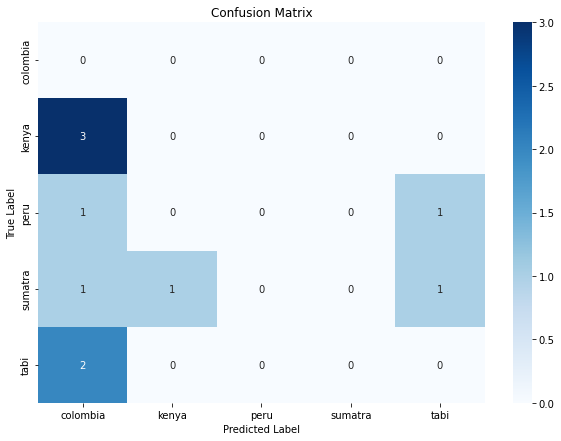

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(cm, bean_names)

In [6]:
model.save("classifier_coffee_3.keras")

Model loaded
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[0 0 0 ... 0 0 0]


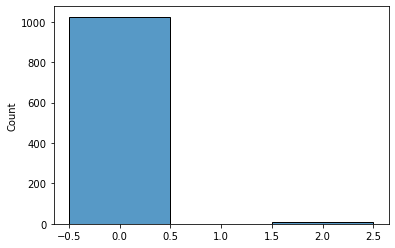

In [7]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import seaborn as sns
import h5py

dataset_path = 'session/group_0/entry_0/result/frame'

# Define preprocessing functions
def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")

def preprocess_data(complex_tensor):
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)
    return combined_input

def load_and_convert_tensor(file_path, dataset_path):
    tensor = extract_tensor_from_h5(file_path, dataset_path)
    complex_tensor = tensor['real'] + 1j * tensor['imag']
    return complex_tensor

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Load and preprocess new data
new_data_tensor = load_and_convert_tensor("sumatra_sample.h5", dataset_path)
new_data_input = preprocess_data(new_data_tensor)
new_data_input = squeeze_data(new_data_input)

# Load the saved model
model = load_model('classifier_coffee_3.keras')
print("Model loaded")

# Make predictions
predictions = model.predict(new_data_input)
predicted_classes = np.argmax(predictions, axis=-1)

# Print predictions
sns.histplot(predicted_classes, discrete=True)
print(predicted_classes)

Model loaded
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0 0 0 ... 0 0 0]


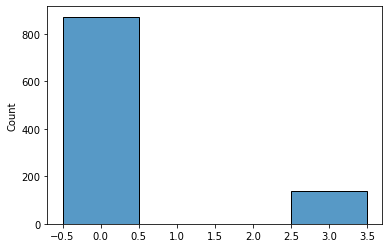

In [8]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import seaborn as sns
import h5py

dataset_path = 'session/group_0/entry_0/result/frame'

# Define preprocessing functions
def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")

def preprocess_data(complex_tensor):
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)
    return combined_input

def load_and_convert_tensor(file_path, dataset_path):
    tensor = extract_tensor_from_h5(file_path, dataset_path)
    complex_tensor = tensor['real'] + 1j * tensor['imag']
    return complex_tensor

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Load and preprocess new data
new_data_tensor = load_and_convert_tensor("peru_sample.h5", dataset_path)
new_data_input = preprocess_data(new_data_tensor)
new_data_input = squeeze_data(new_data_input)

# Load the saved model
model = load_model('classifier_coffee_3.keras')
print("Model loaded")

# Make predictions
predictions = model.predict(new_data_input)
predicted_classes = np.argmax(predictions, axis=-1)

# Print predictions
sns.histplot(predicted_classes, discrete=True)
print(predicted_classes)

Model loaded
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[0 0 0 ... 0 0 0]


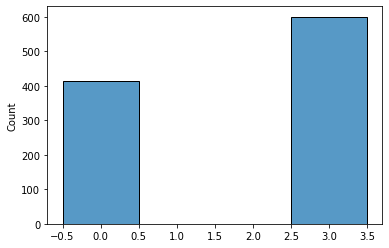

In [9]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import seaborn as sns
import h5py

dataset_path = 'session/group_0/entry_0/result/frame'

# Define preprocessing functions
def extract_tensor_from_h5(file_path, dataset_path):
    """
    Extracts a tensor from an H5 file and checks for non-numerical data.

    Parameters:
    - file_path: str, path to the H5 file
    - dataset_path: str, path to the dataset within the H5 file

    Returns:
    - tensor: numpy.ndarray, the extracted tensor if purely numerical
    """
    with h5py.File(file_path, 'r') as h5file:
        if dataset_path in h5file:
            dataset = h5file[dataset_path]
            tensor = np.array(dataset)

            return tensor
        else:
            raise KeyError(f"Dataset {dataset_path} not found in the file {file_path}")

def preprocess_data(complex_tensor):
    real_part = complex_tensor.real.astype(np.float32)
    imag_part = complex_tensor.imag.astype(np.float32)
    combined_input = np.concatenate([real_part, imag_part], axis=-1)
    return combined_input

def load_and_convert_tensor(file_path, dataset_path):
    tensor = extract_tensor_from_h5(file_path, dataset_path)
    complex_tensor = tensor['real'] + 1j * tensor['imag']
    return complex_tensor

def squeeze_data(data):
    # Remove dimensions of size 1
    return np.squeeze(data, axis=1)

# Load and preprocess new data
new_data_tensor = load_and_convert_tensor("colombia_sample.h5", dataset_path)
new_data_input = preprocess_data(new_data_tensor)
new_data_input = squeeze_data(new_data_input)

# Load the saved model
model = load_model('classifier_coffee_3.keras')
print("Model loaded")

# Make predictions
predictions = model.predict(new_data_input)
predicted_classes = np.argmax(predictions, axis=-1)

# Print predictions
sns.histplot(predicted_classes, discrete=True)
print(predicted_classes)